In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import pickle
import seaborn as sns
import sys
import time

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
plt.style.use('bmh')

sys.path.append('../')

from embedding_analysis import *
from gensim.models import Word2Vec

%pprint # turn pretty printing off 

Pretty printing has been turned OFF


In [2]:
df = pickle.load(open('data/data_malaysia_clean', 'rb'))
print(df.shape)
df.head()

(90855, 8)


,year_month,title,link,time,article,date,tokens,no_tokens
0,2017_April,"Three killed, border policeman injured in Buki...",https://www.malaymail.com/news/malaysia/2017/0...,"Sunday, 30 Apr 2017 10:16 PM MYT",BUKIT KAYU HITAM April 30 — Three people were...,2017-04-01,"[bukit, kayu, hitam, april, three, people, wer...",237
1,2017_April,Motion urging Guan Eng to take leave as chief ...,https://www.malaymail.com/news/malaysia/2017/0...,"Sunday, 30 Apr 2017 09:28 PM MYT","TASEK GELUGOR, April 30 — The motion urging L...",2017-04-01,"[tasek, gelugor, april, the, motion, urging, l...",217
2,2017_April,"Maybe Hadi is the confused one, says Muhyddin",https://www.malaymail.com/news/malaysia/2017/0...,"Sunday, 30 Apr 2017 09:13 PM MYT","PETALING JAYA, April 30 — PAS president Datuk...",2017-04-01,"[petaling, jaya, april, pas, president, datuk,...",185
3,2017_April,Azmin incredulous PAS willing to split with PK...,https://www.malaymail.com/news/malaysia/2017/0...,"Sunday, 30 Apr 2017 08:24 PM MYT","KUALA LUMPUR, April 30 — Selangor Mentri Besa...",2017-04-01,"[kuala, lumpur, april, selangor, mentri, besar...",204
4,2017_April,Indian national with 10kg ketamine hidden betw...,https://www.malaymail.com/news/malaysia/2017/0...,"Sunday, 30 Apr 2017 08:15 PM MYT","KUALA TERENGGANU, April 30 — An Indian nation...",2017-04-01,"[kuala, terengganu, april, an, indian, nationa...",221


# Train word embeddings model

In [17]:
models_by_year = {}

for year in df.date.dt.year.unique():
    texts = df.loc[df.date.dt.year==year, 'tokens']
    models_by_year[year] = Word2Vec(sentences=texts, size=300, window=6, 
                                    min_count=5, workers=10, sg=1, hs=0, negative=5, iter=10,
                                    seed=150)

In [18]:
pickle.dump(models_by_year, open('models/word2vec_by_year_english_300d_6w_val', 'wb'))

# Identify representative group vectors

- Malays:  `'bumiputra', 'bumiputera',  'bumiputeras', 'malays', 'malay', 'malaybumiputera', 'malaybumiputra', 'pribumi', 'bumiputras'`
- Indians: `'indians', 'indian'`
- Chinese: `'chinese'`
- Others: `'nonbumiputeras', 'nonmalays', 'nonbumiputera', 'nonmalay'`

In [19]:
# Load trained models
models_by_year = pickle.load(open('models/word2vec_by_year_english_300d_6w_val', 'rb'))
models_by_year

{2017: <gensim.models.word2vec.Word2Vec object at 0x000001E14FEED940>, 2018: <gensim.models.word2vec.Word2Vec object at 0x000001E14DC94370>, 2019: <gensim.models.word2vec.Word2Vec object at 0x000001E151D822B0>, 2020: <gensim.models.word2vec.Word2Vec object at 0x000001E154D2F8B0>, 2021: <gensim.models.word2vec.Word2Vec object at 0x000001E1508084F0>}

In [20]:
# Examine the usage of group words in each year
malays = ['bumiputra', 'bumiputera', 'malays', 'malay', 'malaybumiputera', 'bumiputeras', 'malaybumiputra', 'pribumi', 'bumiputras']
malays_wo_malay = ['bumiputra', 'bumiputera', 'malays', 'malaybumiputera', 'bumiputeras', 'malaybumiputra', 'pribumi', 'bumiputras']
indians = ['indians', 'indian']
chineses = ['chinese']

for year in range(2017, 2022):
    print(year)
    print([malay for malay in malays if malay in models_by_year[year].wv.vocab])
    print([chinese for chinese in chineses if chinese in models_by_year[year].wv.vocab])
    print([indian for indian in indians if indian in models_by_year[year].wv.vocab])

2017
['bumiputra', 'bumiputera', 'malays', 'malay', 'malaybumiputera', 'bumiputeras', 'pribumi']
['chinese']
['indians', 'indian']
2018
['bumiputra', 'bumiputera', 'malays', 'malay', 'bumiputeras', 'pribumi', 'bumiputras']
['chinese']
['indians', 'indian']
2019
['bumiputra', 'bumiputera', 'malays', 'malay', 'bumiputeras', 'pribumi']
['chinese']
['indians', 'indian']
2020
['bumiputra', 'bumiputera', 'malays', 'malay', 'malaybumiputera', 'bumiputeras', 'pribumi']
['chinese']
['indians', 'indian']
2021
['bumiputra', 'bumiputera', 'malays', 'malay', 'bumiputeras', 'pribumi']
['chinese']
['indians', 'indian']


In [38]:
df_ind = get_freq_by_year(indians, df).sum(axis=0).sort_values(ascending=False).reset_index()
df_ind.columns = ['noun', 'count']
df_ind['group'] = 'Indians'

df_chi = get_freq_by_year(chineses, df).sum(axis=0).sort_values(ascending=False).reset_index()
df_chi.columns = ['noun', 'count']
df_chi['group'] = 'Chinese'

df_mal = get_freq_by_year(malays, df).sum(axis=0).sort_values(ascending=False).reset_index()
df_mal.columns = ['noun', 'count']
df_mal['group'] = 'Malays'

df_bar = pd.concat([df_ind, df_chi, df_mal])
df_bar.head()

,noun,count,group
0,indian,3241,Indians
1,indians,979,Indians
0,chinese,10681,Chinese
0,malay,18440,Malays
1,pribumi,3869,Malays


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


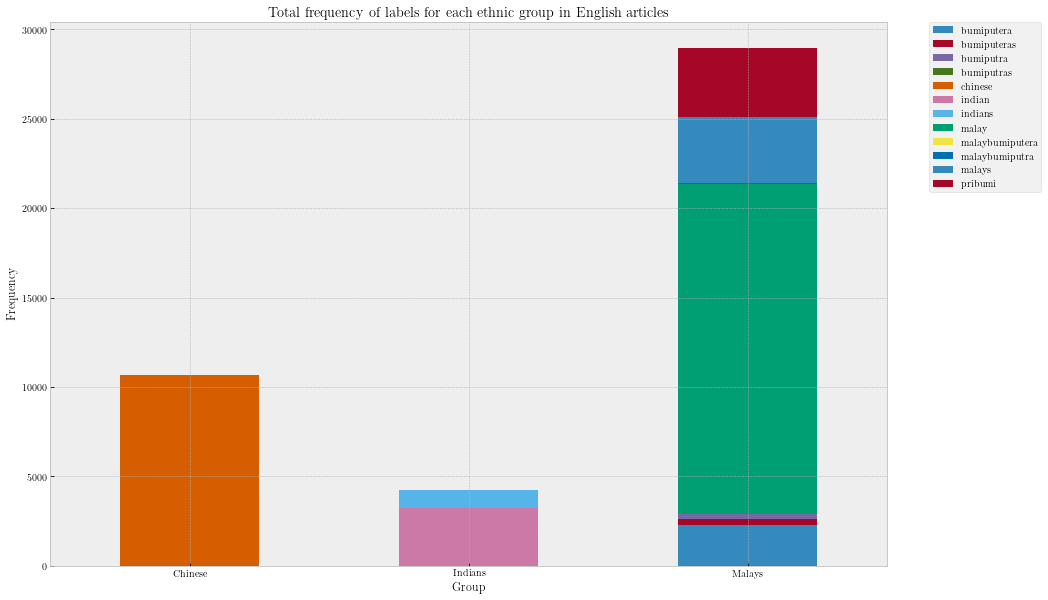

In [39]:
ax = df_bar.pivot(index='group', columns='noun', values='count').plot(kind='bar', stacked=True, figsize=(15, 10))
ax.set_xlabel("Group")
ax.set_ylabel("Frequency")
ax.set_title("Total frequency of labels for each ethnic group in English articles")
plt.xticks(rotation=360)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('figs/english_total_freq_labels.eps', format='eps')

In [40]:
df_ind = get_freq_by_year(indians, df).sum(axis=0).sort_values(ascending=False).reset_index()
df_ind.columns = ['noun', 'count']
df_ind['group'] = 'Indians'

df_chi = get_freq_by_year(chineses, df).sum(axis=0).sort_values(ascending=False).reset_index()
df_chi.columns = ['noun', 'count']
df_chi['group'] = 'Chinese'

df_mal = get_freq_by_year(malays_wo_malay, df).sum(axis=0).sort_values(ascending=False).reset_index()
df_mal.columns = ['noun', 'count']
df_mal['group'] = 'Malays'

df_bar = pd.concat([df_ind, df_chi, df_mal])
df_bar.head()

,noun,count,group
0,indian,3241,Indians
1,indians,979,Indians
0,chinese,10681,Chinese
0,pribumi,3869,Malays
1,malays,3698,Malays


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


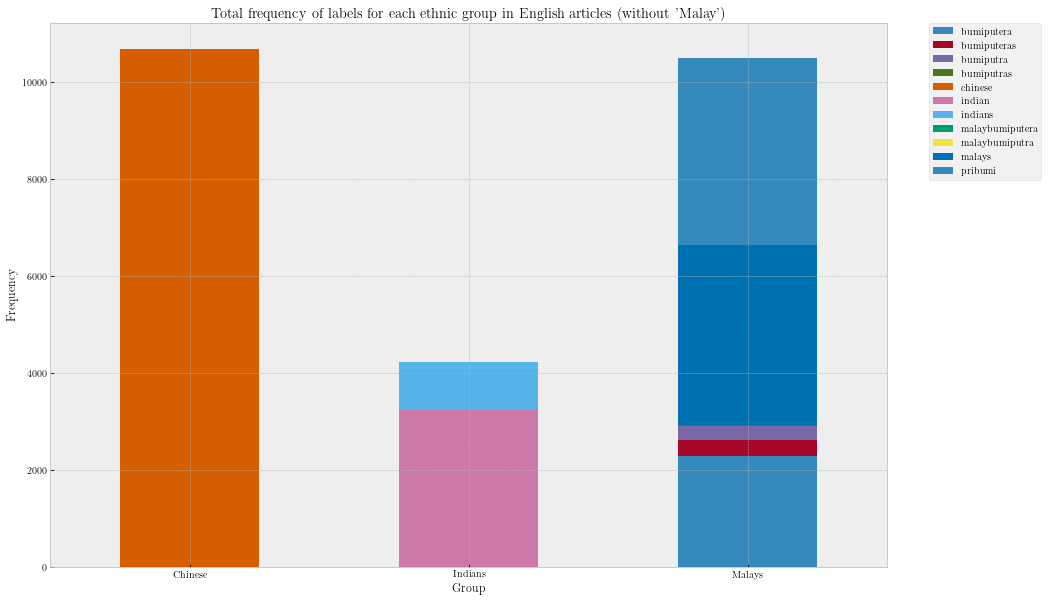

In [41]:
ax = df_bar.pivot(index='group', columns='noun', values='count').plot(kind='bar', stacked=True, figsize=(15, 10))
ax.set_xlabel("Group")
ax.set_ylabel("Frequency")
ax.set_title("Total frequency of labels for each ethnic group in English articles (without 'Malay')")
plt.xticks(rotation=360)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('figs/english_total_freq_labels_wo_malay.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


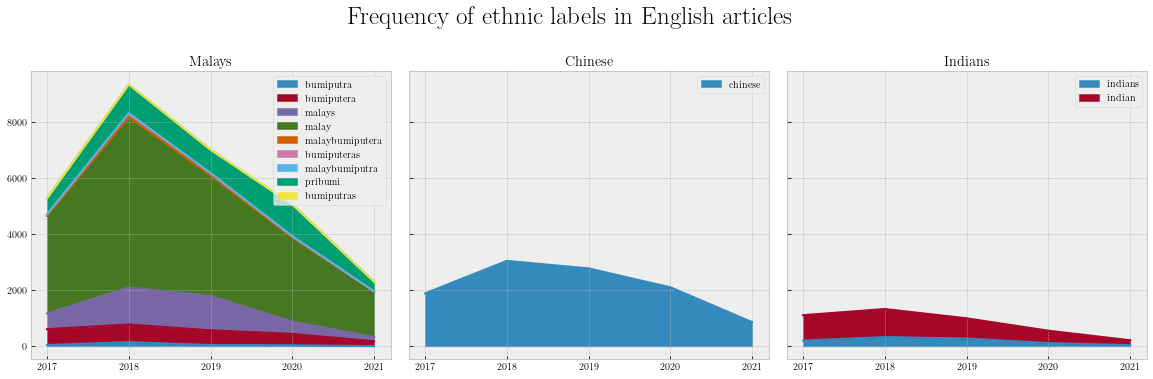

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
axes = axes.flatten()
title = 'Frequency of ethnic labels in English articles'
labels = [malays, chineses, indians]
subtitles = ['Malays', 'Chinese', 'Indians']

for idx in range(len(axes)):
    ax = axes[idx]
    get_freq_by_year(labels[idx], df).plot.area(ax=ax)
#     for p in ax.patches:
#         ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.02))
    ax.locator_params(integer=True)
    ax.set_title(subtitles[idx])

fig.suptitle(title, fontsize=25)
plt.subplots_adjust(top=0.8, bottom=0, wspace=0.05, hspace=0.2)
plt.savefig('figs/english_freq_labels.eps', format='eps')

<AxesSubplot:>

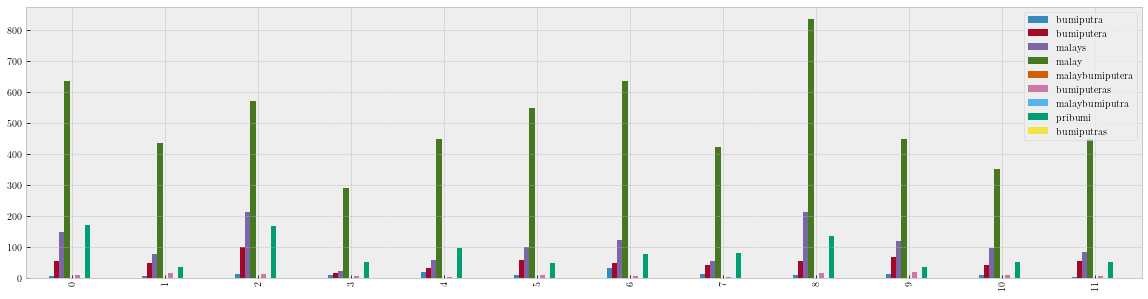

In [48]:
data = df.loc[df.date.dt.year==2018, :]
months = data.date.dt.month.unique()

words = malays
dict_word_count = {word:[] for word in words}

for word in words:
    for month in months:
        count = data.loc[data.date.dt.month == month, 'tokens'].apply(lambda tokens: count_word(word, tokens)).sum()
        
        dict_word_count[word].append(count)
        
data = pd.DataFrame(dict_word_count)
data.set_index(months).sort_index(inplace=True)
data.plot(kind='bar', figsize=(20, 5))

<AxesSubplot:>

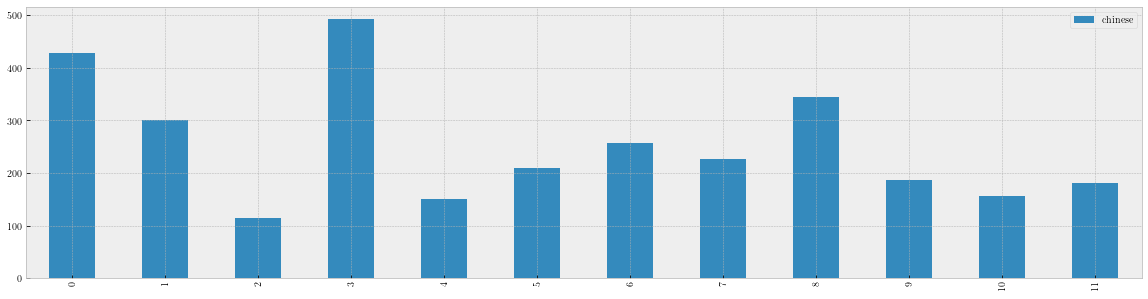

In [49]:
data = df.loc[df.date.dt.year==2018, :]
months = data.date.dt.month.unique()

words = chineses
dict_word_count = {word:[] for word in words}

for word in words:
    for month in months:
        count = data.loc[data.date.dt.month == month, 'tokens'].apply(lambda tokens: count_word(word, tokens)).sum()
        
        dict_word_count[word].append(count)
        
data = pd.DataFrame(dict_word_count)
data.set_index(months).sort_index(inplace=True)
data.plot(kind='bar', figsize=(20, 5))

<AxesSubplot:>

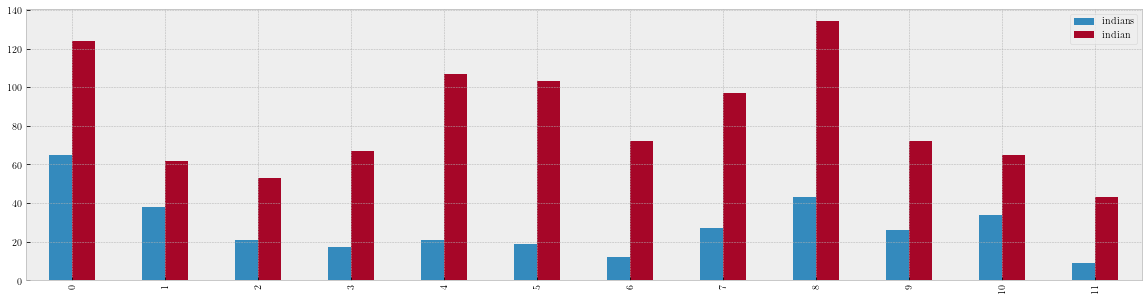

In [50]:
data = df.loc[df.date.dt.year==2018, :]
months = data.date.dt.month.unique()

words = indians
dict_word_count = {word:[] for word in words}

for word in words:
    for month in months:
        count = data.loc[data.date.dt.month == month, 'tokens'].apply(lambda tokens: count_word(word, tokens)).sum()
        
        dict_word_count[word].append(count)
        
data = pd.DataFrame(dict_word_count)
data.set_index(months).sort_index(inplace=True)
data.plot(kind='bar', figsize=(20, 5))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


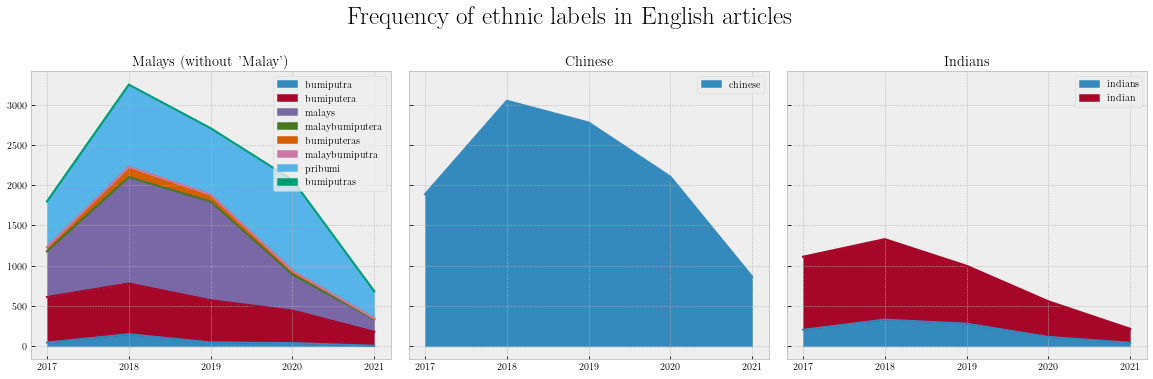

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
axes = axes.flatten()
title = 'Frequency of ethnic labels in English articles'
labels = [malays_wo_malay, chineses, indians]
subtitles = ['Malays (without \'Malay\')', 'Chinese', 'Indians']

for idx in range(len(axes)):
    ax = axes[idx]
    get_freq_by_year(labels[idx], df).plot.area(ax=ax)
    ax.locator_params(integer=True)
    ax.set_title(subtitles[idx])

fig.suptitle(title, fontsize=25)
plt.subplots_adjust(top=0.8, bottom=0, wspace=0.05, hspace=0.2)
plt.savefig('figs/english_freq_labels_wo_malay.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


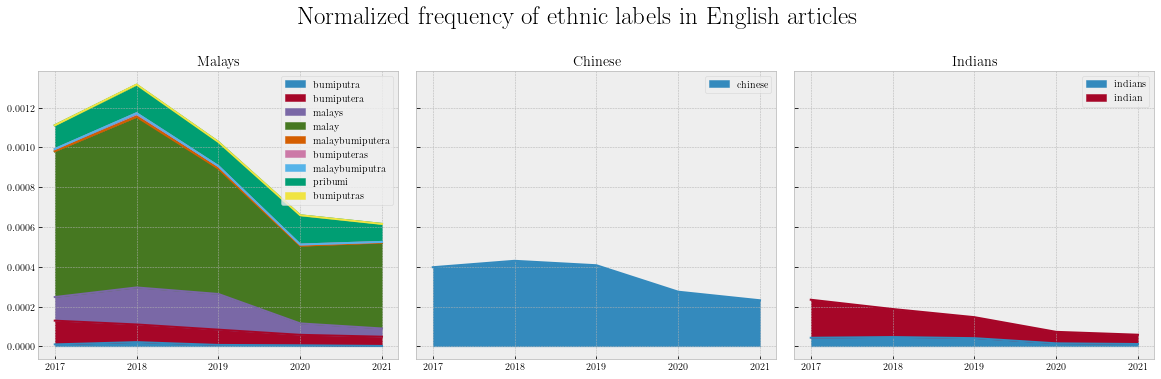

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
axes = axes.flatten()
title = 'Normalized frequency of ethnic labels in English articles'
labels = [malays, chineses, indians]
subtitles = ['Malays', 'Chinese', 'Indians']

for idx in range(len(axes)):
    ax = axes[idx]
    get_freq_by_year(labels[idx], df, True).plot.area(ax=ax)
#     for p in ax.patches:
#         ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.02))
    ax.locator_params(integer=True)
    ax.set_title(subtitles[idx])

fig.suptitle(title, fontsize=25)
plt.subplots_adjust(top=0.8, bottom=0, wspace=0.05, hspace=0.2)
plt.savefig('figs/english_freq_normalized_labels.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


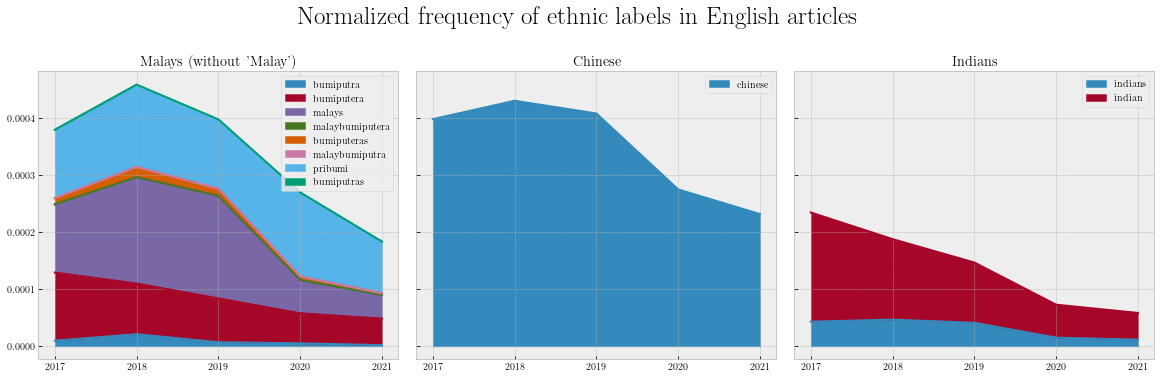

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
axes = axes.flatten()
title = 'Normalized frequency of ethnic labels in English articles'
labels = [malays_wo_malay, chineses, indians]
subtitles = ['Malays (without \'Malay\')', 'Chinese', 'Indians']

for idx in range(len(axes)):
    ax = axes[idx]
    get_freq_by_year(labels[idx], df, True).plot.area(ax=ax)
#     for p in ax.patches:
#         ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.02))
    ax.locator_params(integer=True)
    ax.set_title(subtitles[idx])

fig.suptitle(title, fontsize=25)
plt.subplots_adjust(top=0.8, bottom=0, wspace=0.05, hspace=0.2)
plt.savefig('figs/english_freq_normalized_labels_wo_malay.eps', format='eps')

In [209]:
get_freq_by_year(malays, df).sum(axis=0).sort_values(ascending=False)

malay              18440
pribumi             3869
malays              3698
bumiputera          2294
bumiputeras          314
bumiputra            296
malaybumiputera       16
bumiputras            13
malaybumiputra         3
dtype: int64

In [37]:
get_freq_by_year(chineses, df).sum(axis=0).sort_values(ascending=False)

chinese    10681
dtype: int64

In [38]:
get_freq_by_year(indians, df).sum(axis=0).sort_values(ascending=False)

indian     3241
indians     979
dtype: int64

# Identify stereotypes vectors

- Types of stereotypes
    1. physical appearances
    2. personal qualities
    3. economic status
    4. occupations
 
- Steps of compiling adjectives/nouns for stereotypes (1)-(3)
    1. Select the most common adjectives based on raw frequency 
    2. Select the adjectives that are closest to each ethnic group
    3. Include adjectives of interest

## POS Tagging

In [9]:
import nltk

In [ ]:
# Conduct POS tagging to identify adjectives
adjs = []
for token in df.tokens:
    adjs.extend([word[0] for word in nltk.pos_tag(token) if word[1] == 'JJ'])

len(adjs)

In [11]:
pickle.dump(adjs, open('data/pos_adj', 'wb'))

In [ ]:
# Conduct POS tagging to identify superlatives?????????????
adjs = []
for token in df.tokens:
    adjs.extend([word[0] for word in nltk.pos_tag(token) if word[1] == 'JJ'])

len(adjs)

## 1. Most Common Adjevtives

In [13]:
from wordcloud import WordCloud

In [9]:
adjs = pickle.load(open('data/pos_adj', 'rb'))
adjs = [adj for adj in adjs if len(adj) > 1]
print(len(adjs))

2600661


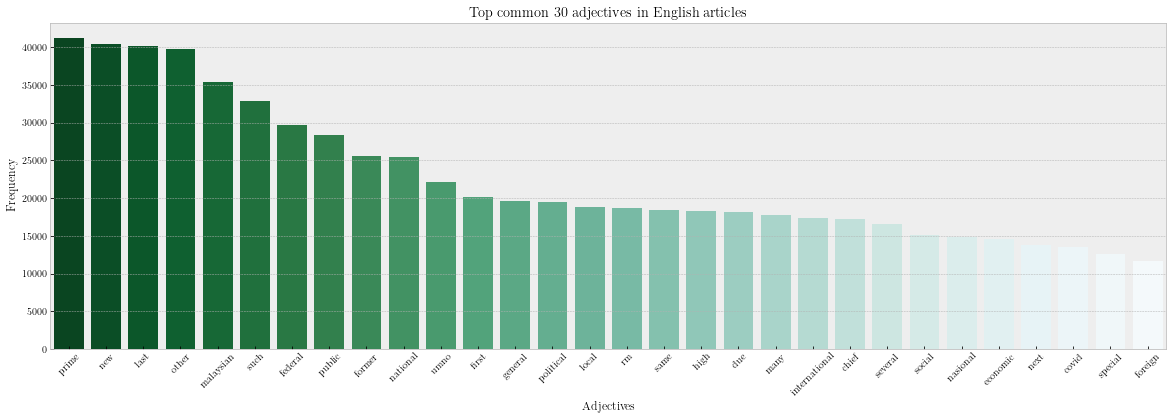

In [6]:
data = pd.Series(adjs).value_counts()[0:30]

fig, ax = plt.subplots(figsize=(20, 6))
ax = sns.barplot(x=data.index,y=data.values, palette="BuGn_r")
ax.set_xlabel("Adjectives")
ax.set_ylabel("Frequency")
ax.set_title("Top common 30 adjectives in English articles")
plt.xticks(rotation=45)
plt.savefig('figs/english_top_adjs.eps', format='eps')

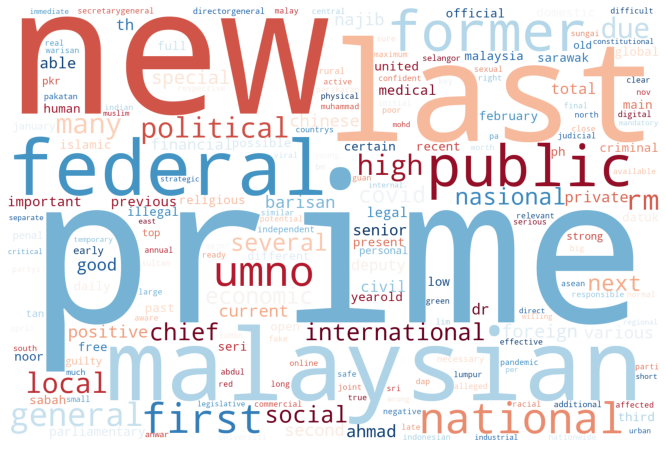

In [43]:
# Plot a word cloud
fig, axs = plt.subplots(figsize=(25, 8))
wordcloud = WordCloud(width=1500, height=1000, 
                      prefer_horizontal=1,
                      background_color='white', 
                      collocations=False, 
                      colormap='RdBu', 
                      relative_scaling = 0.2,
                      min_word_length = 2,
                      min_font_size=15).generate(' '.join(adjs))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [20]:
pd.Series(adjs).value_counts().index[0:200].tolist()

['prime', 'new', 'last', 'other', 'malaysian', 'such', 'federal', 'public', 'former', 'national', 'umno', 'first', 'general', 'political', 'local', 'rm', 'same', 'high', 'due', 'many', 'international', 'chief', 'several', 'social', 'nasional', 'economic', 'next', 'covid', 'i', 'special', 'foreign', 'positive', 'ahmad', 'good', 'second', 'various', 'current', 'chinese', 'barisan', 'private', 'senior', 'dr', 'th', 'own', 'deputy', 'total', 'civil', 'financial', 'able', 'previous', 'important', 'further', 'medical', 'legal', 'parliamentary', 'religious', 'islamic', 'criminal', 'noor', 'najib', 'present', 'low', 'official', 'united', 'human', 'february', 'open', 'sabah', 'full', 'malaysias', 'third', 'recent', 'global', 'daily', 'yearold', 'seri', 'possible', 'main', 'domestic', 'free', 'past', 'datuk', 'sarawak', 'certain', 'ph', 'illegal', 'different', 'personal', 'early', 'january', 'guilty', 'few', 'old', 'tan', 'top', 'penal', 'strong', 'independent', 'necessary', 'rural', 'directorge

In [148]:
words = set(nltk.corpus.words.words())

def get_english_word(words, english_cor):
    return [word for word in words if word in english_cor]

In [149]:
pd.Series(get_english_word(adjs, words)).value_counts().index[0:200].tolist()

['prime', 'new', 'last', 'other', 'such', 'federal', 'public', 'former', 'national', 'first', 'general', 'political', 'local', 'same', 'high', 'due', 'many', 'international', 'chief', 'several', 'social', 'economic', 'next', 'covid', 'i', 'special', 'foreign', 'positive', 'good', 'second', 'various', 'current', 'private', 'senior', 'th', 'own', 'deputy', 'total', 'civil', 'financial', 'able', 'previous', 'important', 'further', 'medical', 'legal', 'parliamentary', 'religious', 'criminal', 'present', 'low', 'official', 'united', 'human', 'open', 'full', 'third', 'recent', 'global', 'daily', 'possible', 'main', 'domestic', 'free', 'past', 'certain', 'illegal', 'different', 'personal', 'early', 'guilty', 'few', 'old', 'tan', 'top', 'penal', 'strong', 'independent', 'necessary', 'rural', 'additional', 'small', 'major', 'much', 'digital', 'long', 'similar', 'effective', 'clear', 'young', 'available', 'relevant', 'late', 'respective', 'close', 'central', 'negative', 'nationwide', 'right', 'b

- physical appearances: `'old', 'young'`
- personal qualities: `'good', 'religious', 'criminal', 'united', 'open', 'free', strong', 'independent', 'negative', 'positive', 'responsible', 'fake', 'active', 'confident', 'great','popular', 'bad'`
- economic status: `'poorest', 'rural', 'urban', 'industrial'`

## 2. Closest Adjectives to Ethnic Groups

- the adjectives close to `bumiputra` and `bumiputera` consist of lots of malay words and acronyms that refer to organizations
    - reveals the usage of `bumiputra` in contrast to `malays`

In [215]:
dict_adj_malay = get_close_adj(malays, models_by_year, adjs, n=200)
dict_adj_malay.keys()

dict_keys(['bumiputra', 'bumiputera', 'malays', 'malay', 'malaybumiputera', 'bumiputeras', 'malaybumiputra', 'pribumi', 'bumiputras'])

In [238]:
dict_adj_malay['bumiputras']

{'mediumincome', 'employable', 'governmentaided', 'ntps', 'ptsn', 'midincome', 'jiao', 'grouped', 'antibullying', 'tribes', 'proficient', 'englishspeaking', 'semirural', 'utan', 'extracurricular', 'nonchinese', 'mip', 'ipg', 'migrated', 'insecurity', 'pessimistic', 'unmarried', 'disenchanted', 'ipta', 'incubator', 'noncitizens', 'nonbumiputera', 'bumiputeras', 'nonbumiputeras', 'ethnocentric', 'ukms', 'indians', 'sumbangan', 'cgpa', 'quotas', 'bs', 'sbp', 'penchala', 'underserved', 'malaydominated', 'lagged', 'anaemia', 'spmlevel', 'underutilised', 'takeup', 'simpai', 'sikhs', 'onefifth', 'rmt', 'sizable', 'sjkcs', 'highskilled', 'nutritious', 'hinai', 'schoolchildren', 'kdm', 'chiku', 'expat', 'chinesemedium', 'psychosocial', 'suluk', 'sjk', 'danesh', 'welltodo', 'ekasih', 'syam', 'mixedrace', 'punjabi', 'apathetic', 'vocabulary', 'bajau', 'kembung', 'dayaks', 'uecs', 'disadvantaged', 'mgs', 'bandau', 'higherincome', 'miniscule', 'millionstrong', 'needsbased', 'primed', 'overweight', 

In [239]:
get_english_word(dict_adj_malay['bumiputras'], words)

['employable', 'grouped', 'proficient', 'semirural', 'extracurricular', 'insecurity', 'pessimistic', 'unmarried', 'incubator', 'ethnocentric', 'lagged', 'anaemia', 'simpai', 'sizable', 'nutritious', 'psychosocial', 'apathetic', 'vocabulary', 'overweight', 'semiskilled', 'lad', 'undeveloped', 'semiurban', 'meagre', 'stam', 'missionary']

- physical appearances: `'slim', 'bald', 'beautiful' `
- personal qualities: `'pluralistic', 'evangelical', 'staunch', 'tumultuous', 'undignified', 'socialist', 'apolitical', 'chauvinist', 'homogenous', 'probumiputera', 'aspiring', 'embattled', 'grassroot', 'negligible', 'illiterate', 'ace', 'superb', 'highskilled', 'loyalist', 'ethnocentric', 'halfhearted', 'strategist', 'nativist', 'contented', 'patriots', 'undivided', 'upbeat', 'fledgling', 'inexperienced', 'pessimistic', 'semiskilled', 'forgiving', 'ultraconservative', 'exploiting', 'malaycentric', 'infidels', 'greedy', 'unprincipled', 'stingy', 'formidable', 'rightwing', 'apathetic', 'religiousbased', 'fractious', 'approachable', 'conservative', 'hardline', 'coward', 'gullible', 'energetic', 'racebased', 'powercrazy', 'obedient', 'antiestablishment', 'chinesebased', 'cynical', 'dominant', 'magnanimous', 'despicable', 'fickle', 'indianbased', 'racist', 'chauvinistic', 'antimalay', 'centrist', 'powerhungry', 'insecure', 'secular', 'hypocritical', 'clueless', 'appreciative', 'disrespectful', 'authoritarian', 'disunited', 'lazy', 'oblivious', 'arrogant', 'cursed', 'undecided', 'treacherous', 'loyal', 'plural', 'delusional', 'ungrateful', 'mistreated', 'rational', 'shortchanged', 'antiislam', 'liberal', 'superficial', 'dismissive', 'persuadable', 'disgusting', 'autocratic', 'faithful', 'disloyal', 'pathetic', 'overconfident', 'disparate', 'polarised', 'multireligious', 'disenfranchised', 'malaybased', 'nationalistic', 'bullied', 'commanded', 'friendlier', 'kleptocrat', 'bogeyman', 'saviour', 'antigovernment', 'openminded', 'tolerant', 'nationalist', 'fragmented', 'divisive', 'multicultural', 'bereft', 'disenchanted', 'disillusioned', 'rebellious', 'indecisive', 'colonised', 'disheartened', 'predictable', 'kleptocratic', 'diehard', 'fedup', 'ethnoreligious', 'scandalplagued', 'hypocrite', 'passionate', 'antichinese', 'insolent',  'entrapped', 'pious', 'fractured', 'narrowminded', 'multiethnic', 'principled', 'bumiputeracentric', 'prolific', 'nonpartisan', 'weakest', 'courted', 'incensed', 'fundamentalist', 'estranged', 'bilingual', 'leftist', 'humorous', 'ecstatic', 'upset', 'soft-spoken', 'youthcentric', 'enterprising', 'dangling', 'lowskilled', 'idealistic', 'sensible', 'diligent', 'smarter', 'highlyskilled', 'unskilled', 'indifferent',  'farsighted', 'receptive', 'fearless', 'selfish', 'wellversed',  'empathetic', 'healthier', 'futureready','knowledgeable', 'skilled', 'elitist', 'budding', 'materialistic', 'passive', 'choosy', 'stunted', 'productive', 'entrepreneurial', 'employable', 'assertive', 'underserved', 'talented', 'unqualified', 'unrealistic', 'savvy', 'adaptable', 'frail', 'inefficient', 'tame', 'nascent', 'rudderless', 'dismayed', 'outgoing', 'reformist'， 'vigorous', 'antikleptocracy', 'antibullying', 'proficient'`
- socioeconomic status: `'governmentaided', 'underdeveloped', 'powerless', 'semiurban', 'marginalised', 'suppressed', 'middleclass', 'sidelined', 'forgotten', 'urbanites',  'semirural', 'welloff', 'insignificant', 'workingclass', 'underrepresented', 'richer', 'urbanised', 'disadvantaged', 'highincome', 'lowerincome', 'higherincome', 'impoverished', 'lowwage', 'mediumincome', 'midincome', 'selfreliant', 'suburban', 'poorer', 'middleincome'`

In [242]:
dict_adj_chi = get_close_adj(chineses, models_by_year, adjs, n=200)
dict_adj_chi

{'chinese': {'minh', 'wuhan', 'penan', 'musical', 'herbs', 'alibaba', 'papua', 'lively', 'eightmember', 'vibes', 'boatman', 'noisy', 'malayislamic', 'arabic', 'smjk', 'foodstuff', 'primas', 'aidilfitri', 'nonbumiputera', 'cherished', 'ethnic', 'ivy', 'malaymuslims', 'wrestle', 'iban', 'consulategeneral', 'gawai', 'secondary', 'antibn', 'pure', 'huang', 'customarily', 'chinesemajority', 'pccci', 'signboard', 'makkal', 'bmspeaking', 'amman', 'comic', 'breakaway', 'cina', 'chengdu', 'phantom', 'hometowns', 'lunar', 'sccci', 'hainan', 'expatriates', 'dpmm', 'capella', 'caide', 'hakka', 'joyous', 'festive', 'rightwing', 'chatime', 'freemason', 'festival', 'koks', 'mbam', 'apathetic', 'enrollment', 'basketball', 'credits', 'deva', 'cantonese', 'puasa', 'twentyfour', 'penangite', 'yearlong', 'mei', 'millionstrong', 'fluent', 'bumiputera', 'instigate', 'harvest', 'monthlong', 'le', 'cis', 'vietnamese', 'rev', 'jiang', 'yuan', 'swing', 'enriched', 'cuisine', 'hubei', 'siamese', 'irish', 'wesak'

In [245]:
get_english_word(dict_adj_chi['chinese'], words)

['musical', 'lively', 'boatman', 'noisy', 'foodstuff', 'ethnic', 'ivy', 'wrestle', 'secondary', 'pure', 'customarily', 'signboard', 'amman', 'comic', 'breakaway', 'phantom', 'lunar', 'joyous', 'festive', 'freemason', 'festival', 'apathetic', 'enrollment', 'basketball', 'deva', 'yearlong', 'fluent', 'instigate', 'harvest', 'rev', 'yuan', 'swing', 'cuisine', 'celebrated', 'hateful', 'enrolment', 'sideline', 'pomelo', 'ninety', 'dragon', 'mike', 'commerce', 'populous', 'revival', 'mib', 'nomadic', 'dominate', 'vie', 'intangible', 'enclave', 'odd', 'glorious', 'fa', 'traditional', 'methodist', 'panelist', 'thanksgiving', 'herbal', 'forty', 'bountiful', 'millennial', 'ash', 'spoilt', 'luncheon', 'chauvinistic', 'dong', 'lion', 'embassy', 'farewell', 'complementary', 'ox', 'forceful', 'resemble', 'rupiah', 'swung', 'sleeve', 'fiddle', 'vernacular', 'cumulatively', 'holy', 'auspicious', 'shanghai', 'li', 'undecided', 'suggestive', 'easter', 'parade', 'fortune', 'degrade', 'chap', 'hockey', 's

- physical appearances: 
- personal qualities: `'musical', 'lively', 'joyous', 'cherished'. 'rightwing', 'apathetic', 'hateful', 'traditional', 'millennial', 'indianbased', chauvinistic', 'antimalay', 'forceful',  'disunited', 'holy', 'muted',  'thrilled', 'bilingual', 'ethnocentric', 'persuadable', 'loyalist', 'unhappy', 'faithful', 'commanded', 'nationalistic',  'negligible', 'beleaguered', 'forthright', 'homogenous', 'nationalist', 'enterprising', 'disenchanted', 'chauvinist', 'brisk', 'underperforming', 'trilingual', 'fledgling', 'antichinese', 'ethnicbased', 'communist', 'noisy', 'nomadic'`
- socioeconomic status: `'impoverished', 'semirural', 'suburb', 'wealthy', 'semiurban', 'urbanites', 'provincial'`

In [247]:
dict_adj_ind = get_close_adj(indians, models_by_year, adjs, n=200)
dict_adj_ind.keys()

dict_keys(['indians', 'indian'])

In [251]:
dict_adj_ind['indian']

{'wuhan', 'bulgaria', 'penan', 'ek', 'unduk', 'pharmacist', 'sixcorner', 'ltte', 'boatman', 'muftis', 'televangelist', 'namibian', 'malayislamic', 'variant', 'mbba', 'unmarried', 'subramaniam', 'mac', 'primas', 'rohingya', 'chinese', 'nonbumiputera', 'cherished', 'ethnic', 'thosai', 'oppressed', 'socioeconomic', 'taiwanese', 'comparative', 'paramilitary', 'malaycentric', 'entrepreneurs', 'iban', 'consulategeneral', 'notorious', 'shankar', 'local', 'jelai', 'myanmarese', 'vwp', 'immigrant', 'nonrohingya', 'riyadh', 'indigenous', 'favouring', 'thanuja', 'huang', 'onward', 'customarily', 'religiouslinked', 'sivarraajh', 'rebel', 'makkal', 'amman', 'outfit', 'chennai', 'chengdu', 'unmapped', 'phantom', 'lunar', 'sccci', 'er', 'hainan', 'oldest', 'dpmm', 'capella', 'hakka', 'journal', 'cairo', 'resettled', 'pmla', 'houthi', 'threefold', 'commissioned', 'ten', 'apathetic', 'basketball', 'lgbti', 'kembung', 'deva', 'intersex', 'bangkok', 'rajinikanth', 'twentyfour', 'tunisian', 'nationality',

In [253]:
get_english_word(dict_adj_ind['indian'], words)

['pharmacist', 'boatman', 'variant', 'unmarried', 'mac', 'ethnic', 'oppressed', 'socioeconomic', 'comparative', 'paramilitary', 'notorious', 'local', 'immigrant', 'indigenous', 'onward', 'customarily', 'rebel', 'amman', 'outfit', 'unmapped', 'phantom', 'lunar', 'er', 'journal', 'threefold', 'ten', 'apathetic', 'basketball', 'deva', 'intersex', 'bangkok', 'nationality', 'malar', 'unskilled', 'orang', 'cuisine', 'uneasiness', 'queer', 'kachin', 'oilseed', 'pomfret', 'xenophobia', 'mike', 'commerce', 'uplifting', 'populous', 'mib', 'grouper', 'nineteen', 'soybean', 'dominate', 'garlic', 'odd', 'directorate', 'wounded', 'overt', 'anam', 'serum', 'chad', 'unconvincing', 'archipelago', 'diligent', 'sectarian', 'seventy', 'devoted', 'spat', 'atlantic', 'costume', 'appreciative', 'ani', 'centric', 'mutant', 'unidentified', 'cumulatively', 'automobile', 'undecided', 'gay', 'baht', 'triad', 'hockey', 'respectable', 'semirural', 'southern', 'troupe', 'sixty', 'ethnocentric', 'belittle', 'preacher

- physical appearances: `'overweight', 'obese', 'middleaged'`
- personal qualities: `'musical', 'underrepresented', 'xenophobic', 'marginalised', 'oppressed', 'malaycentric', 'struggled', 'shunned', 'indigenous', 'formidable', 'envious', 'neglected', 'resettled', 'accommodating', 'reflective', 'unskilled', 'indifferent', 'disapproving', 'conservative', 'hateful', 'spirited', 'racebased', 'segregated', 'migrated', 'ignorant', 'hated', 'despicable', 'lowskilled', 'skeptical', 'dissatisfied', 'millennial', 'indianbased', 'diligent', 'disrespectful', 'disunited', 'corrupted', 'lazy', 'dominating', 'uneducated', 'treacherous', 'plural',  'pessimistic', 'traumatised', 'shortchanged', 'ethnocentric', 'superficial', 'stunted', 'unhappy', 'disloyal', 'pathetic', 'ridiculed', 'betrayed', 'disenfranchised', 'undocumented', 'illiterate', 'negligible', 'antigovernment', 'grassroot', 'incarcerated', 'nationalist', 'disenchanted', 'chauvinist', 'trustworthy', 'disheartened', 'semiskilled', 'passionate', 'antichinese', 'ethnicbased', 'communist', 'fractured', 'genderbased', 'notorious', 'religiouslinked', 'apathetic', 'unskilled', 'antiestablishment', 'lowskilled',  'wellrespected', 'indianbased', 'appreciative', 'respectable', 'prodemocracy', 'reputable', 'beleaguered', 'aggrieved', 'separatist'`
- socioeconomic status: `'richer', 'middleclass', 'privileged', 'lowerincome', 'higherincome', 'impoverished', 'semirural', 'lowwage', 'affluent', 'underemployed', 'wealthy', 'semiurban', 'mediumincome', 'ultrarich', 'urbanites', 'welloff', 'insignificant', 'disadvantaged', 'poorer', 'provincial'`

## 3. Adjectives of Interest

- physical appearances:
- personal qualities: `'antiislam', 'antimalay', 'antichinese', 'uncivilised', 'unprofessional', 'hurtful', 'sinful', 'shameful', 'unethical', 'rude', 'nasty', 'opportunist', 'clever', 'unwise', 'selfserving', 'misguided', 'fool', 'antigovernment', 'ungrateful', 'radicalised'`
- socioeconomic status: `'underprivileged'`

## 4. Occupations

- Occupations of interest
    - `'educator', 'influencer', 'obstetrician', 'housewives', 'academician', 'chefs', 'educationists', 'carmaker', 'educationist', 'pharmacist', 
    'televangelist', 'entrepreneurs', 'agropreneur', 'farmer', 'boatman'`    
- Bolukbasi et al. (2016):
    - `'teacher', 'author', 'mechanic', 'broker', 'baker', 'surveyor', 'laborer', 'surgeon', 'gardener', 'painter', 'dentist', 'janitor', ' athlete', 'manager', 'conductor', 'carpenter', 'housekeeper', 'secretary', 'economist', 'geologist', 'clerk', 'doctor', 'judge', 'physician', ' lawyer', 'artist', 'instructor', 'dancer', 'photographer', 'inspector', 'musician', 'soldier', 'librarian', 'professor', 'psychologist', ' nurse', 'sailor', 'accountant', 'architect', 'chemist', 'administrator', 'physicist', 'scientist', 'farmer'`

- Garg et al (2018):
   -  `'janitor', 'statistician', 'midwife', 'midwives', 'bailiff', 'auctioneer', 'photographer', 'geologist', 'shoemaker', 'athlete', 'cashier', 'dancer', 'housekeeper', 'accountant', 'physicist', 'gardener', 'dentist', 'weaver', 'blacksmith', 'psychologist', 'supervisor', 'mathematician', 'surveyor', 'tailor', 'designer', 'economist', 'mechanic', 'laborer', 'postmaster', 'broker', 'chemist', 'librarian', 'attendant', 'clerical', 'musician', 'porter', 'scientist', 'carpenter', 'sailor', 'instructor', 'sheriff', 'pilot', 'inspector', 'mason', 'baker', 'administrator', 'architect', 'collector', 'operator', 'surgeon', 'driver', 'painter', 'conductor', 'nurse', 'cook', 'engineer', 'retired', 'sales', 'lawyer', 'clergy', 'physician', 'farmer', 'clerk', 'manager', 'guard', 'artist', 'smith', 'official', 'police', 'doctor', 'professor', 'student', 'judge', 'teacher', 'author', 'secretary', 'soldier'`

# Calculate cosine distance between vectors

In [21]:
malays_filtered = filter_word_by_occurrence(malays, models_by_year)
print(malays_filtered)

chinese_filtered = filter_word_by_occurrence(chineses, models_by_year)
print(chinese_filtered)

indians_filtered = filter_word_by_occurrence(indians, models_by_year)
print(indians_filtered)

['bumiputra', 'bumiputera', 'malays', 'malay', 'bumiputeras', 'pribumi']
['chinese']
['indians', 'indian']


In [22]:
adjs = set(adjs)
len(adjs)

47569

## Identify closest words and adjectives 

In [9]:
for malay in malays_filtered:
    print(malay)
    print(get_close_word(malay, models_by_year, 10).to_markdown())

bumiputra
|      | 0             | 1          | 2          | 3          | 4              | 5            | 6          | 7           | 8          | 9           |
|-----:|:--------------|:-----------|:-----------|:-----------|:---------------|:-------------|:-----------|:------------|:-----------|:------------|
| 2017 | nonbumiputera | bumi       | bumiputera | asb        | bmf            | facilitation | peneraju   | comparative | teras      | hartanah    |
| 2018 | pesaka        | bumiputera | pbb        | kuota      | sumbangan      | bersatus     | ypb        | berkhidmat  | triennial  | pelaburan   |
| 2019 | pesaka        | bumiputera | bansa      | pbb        | solidariti     | pkbm         | satok      | hartanah    | murut      | bidayuh     |
| 2020 | pesaka        | progresif  | jaziri     | demokratik | miniconvention | jaraiee      | bumiputera | pelaburan   | semalaysia | bansa       |
| 2021 | pesaka        | progresif  | mra        | ppbm       | demokrat       | sosialis 

In [9]:
get_close_word('malays', models_by_year, 20)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
2017,indians,erode,nonmalays,nonmalay,bastion,mudah,ibans,natives,heartlands,kadazans,bumiputeras,kingmakers,racebased,wooing,monopolise,conservatives,kdm,oblivious,underclass,heartland
2018,bumiputeras,indians,ethnic,kadazans,ibans,nonmalays,natives,dayaks,ethnocentric,fundamentalists,colonialists,ethnicities,antibn,malaydominated,pendatang,freemason,races,racists,proumno,battled
2019,kadazans,malaymuslims,indians,ibans,nonmalays,disunited,bumiputera,belittle,domination,kingmakers,insecurities,bumiputeras,semirural,socialists,dayaks,dominates,waning,deviants,promalay,animism
2020,malaybumiputera,ethnic,bumiputeras,slims,chauvinist,nationalists,alienate,nonbumiputeras,demography,sympathisers,resonate,kleptocrat,unifying,racists,malaymuslims,heartland,natives,minorities,indians,cowards
2021,electorate,indians,nonmalays,nonmalay,discord,creed,ballots,garner,races,formidable,multiethnic,leaning,gerrymandering,charisma,inclined,malaymuslim,kdm,conservative,semenanjung,eyeing


In [13]:
get_close_adj_by_year('malays', models_by_year, adjs, 20)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
2017,indians,nonmalays,nonmalay,mudah,bumiputeras,racebased,kdm,oblivious,antichinese,instigate,disenfranchised,malaybased,malaymuslims,puyok,hated,illiterate,uniting,antimalay,entrenched,undecided
2018,bumiputeras,indians,ethnic,nonmalays,dayaks,ethnocentric,antibn,malaydominated,pendatang,freemason,proumno,malaymuslims,bumiputera,malaymuslim,primed,infidels,chauvinist,polarised,equate,disenchanted
2019,malaymuslims,indians,nonmalays,disunited,bumiputera,belittle,bumiputeras,semirural,dayaks,waning,disillusioned,unwillingness,malayislam,malaycentric,antimalay,pluralistic,malay,entrapped,communitys,muslims
2020,malaybumiputera,ethnic,bumiputeras,slims,chauvinist,nonbumiputeras,kleptocrat,unifying,malaymuslims,indians,dayaks,betrays,antimalay,conservative,malaydominant,umnopas,generalised,kadazan,antichinese,kadazandusun
2021,electorate,indians,nonmalays,nonmalay,discord,formidable,multiethnic,inclined,malaymuslim,kdm,conservative,semenanjung,enmity,malaymajority,parachute,disunity,bumiputeras,liberalism,ethnicity,disrespectful


In [10]:
for chinese in chinese_filtered:
    print(chinese)
    print(get_close_word(chinese, models_by_year, 10).to_markdown())

chinese
|      | 0          | 1            | 2       | 3       | 4            | 5        | 6             | 7       | 8          | 9          |
|-----:|:-----------|:-------------|:--------|:--------|:-------------|:---------|:--------------|:--------|:-----------|:-----------|
| 2017 | vernacular | nationaltype | indians | indian  | ethnic       | jiao     | tamil         | zong    | nationals  | parentage  |
| 2018 | guilds     | indians      | ethnic  | hokkien | ibans        | kadazans | vernacular    | punjabi | zong       | huazong    |
| 2019 | indians    | kadazans     | indian  | ethnic  | ibans        | zheng    | educationists | siamese | lunar      | nonchinese |
| 2020 | nationals  | indians      | indian  | cny     | educationist | ethnic   | decorations   | lunar   | clan       | ghosts     |
| 2021 | lunar      | indian       | oranges | clan    | hokkien      | lantern  | countdown     | usher   | chauvinist | eve        |


In [11]:
get_close_word('chinese', models_by_year, 20)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
2017,vernacular,nationaltype,indians,indian,ethnic,jiao,tamil,zong,nationals,parentage,automaker,zongs,nonchinese,telugu,huazong,emigration,dpmm,sjkcs,siamese,overwhelmingly
2018,guilds,indians,ethnic,hokkien,ibans,kadazans,vernacular,punjabi,zong,huazong,telugu,malays,colonialists,indian,rooster,keqiang,iban,predominantly,jiao,xi
2019,indians,kadazans,indian,ethnic,ibans,zheng,educationists,siamese,lunar,nonchinese,phantom,zhao,fictitious,wooing,kadazan,pau,outnumber,zhong,alienate,spenders
2020,nationals,indians,indian,cny,educationist,ethnic,decorations,lunar,clan,ghosts,chinas,teochew,ibans,china,lanterns,redcoloured,bai,nonchinese,sikhs,kadazandusun
2021,lunar,indian,oranges,clan,hokkien,lantern,countdown,usher,chauvinist,eve,reunion,dayak,kadazan,tombsweeping,sccci,christmas,celebrating,celebrations,buddhists,cny


In [12]:
get_close_adj_by_year('chinese', models_by_year, adjs, 20)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
2017,vernacular,nationaltype,indians,indian,ethnic,jiao,tamil,zong,nonchinese,telugu,huazong,dpmm,sjkcs,siamese,smjk,bidayuh,boatman,hokkien,nadu,lunar
2018,indians,ethnic,hokkien,vernacular,punjabi,zong,huazong,telugu,malays,indian,rooster,iban,predominantly,jiao,xi,chinas,bidayuh,kadazan,mandarin,closeknit
2019,indians,indian,ethnic,zheng,educationists,siamese,lunar,nonchinese,phantom,fictitious,kadazan,pau,zhong,odd,zodiac,misbehaviour,chinesebased,malays,rantaus,constituencys
2020,indians,indian,cny,educationist,ethnic,lunar,clan,chinas,teochew,china,redcoloured,bai,nonchinese,sikhs,kadazandusun,bogeyman,kadazan,provincial,hokkien,hainan
2021,lunar,indian,clan,hokkien,lantern,countdown,usher,chauvinist,eve,dayak,kadazan,tombsweeping,sccci,christmas,cny,thai,tamil,dragon,xi,festival


In [14]:
for indian in indians_filtered:
    print(indian)
    print(get_close_word(indian, models_by_year, 10).to_markdown())

indians
|      | 0           | 1         | 2      | 3          | 4          | 5          | 6           | 7               | 8              | 9            |
|-----:|:------------|:----------|:-------|:-----------|:-----------|:-----------|:------------|:----------------|:---------------|:-------------|
| 2017 | kadazans    | ethnic    | malays | ibans      | sizeable   | underclass | nonmalay    | disenfranchised | overwhelmingly | bangladeshis |
| 2018 | ibans       | kadazans  | malays | ethnic     | bumiputras | natives    | ethnicities | primed          | indian         | sikhs        |
| 2019 | kadazans    | ibans     | malays | chinese    | ethnic     | rantaus    | semirural   | ultrarich       | grooms         | aslimajority |
| 2020 | ethnic      | kadazan   | ibans  | indian     | pakistanis | chinese    | females     | sikhs           | ethnicity      | percentages  |
| 2021 | ethnicities | ethnicity | ethnic | electorate | malays     | males      | kadazan     | liberalism   

In [15]:
get_close_word('indians', models_by_year, 20)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
2017,kadazans,ethnic,malays,ibans,sizeable,underclass,nonmalay,disenfranchised,overwhelmingly,bangladeshis,kingmakers,malaymuslims,ethnicities,pakistanis,kdm,dayaks,chinese,bidayuh,nonbumiputera,buddhists
2018,ibans,kadazans,malays,ethnic,bumiputras,natives,ethnicities,primed,indian,sikhs,bumiputeras,pendatang,nonmalays,battled,homosexuals,chinese,overwhelmingly,harmoniously,communitys,statelessness
2019,kadazans,ibans,malays,chinese,ethnic,rantaus,semirural,ultrarich,grooms,aslimajority,kadazan,ethnicities,indian,dayaks,sizeable,middleclass,heartland,voters,spenders,semiurban
2020,ethnic,kadazan,ibans,indian,pakistanis,chinese,females,sikhs,ethnicity,percentages,ethnicities,raciallycharged,malays,natives,europeans,indifferent,bumiputeras,burmese,sixty,bogeyman
2021,ethnicities,ethnicity,ethnic,electorate,malays,males,kadazan,liberalism,discord,sympathisers,cultures,nonmalays,z,pessimistic,impunity,rohingyas,millennials,demographic,inclined,races


In [16]:
get_close_adj_by_year('indians', models_by_year, adjs, 20)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
2017,ethnic,malays,sizeable,nonmalay,disenfranchised,bangladeshis,malaymuslims,pakistanis,kdm,dayaks,chinese,bidayuh,nonbumiputera,welloff,communitys,indian,millionstrong,undecided,grouped,malaybumiputera
2018,malays,ethnic,primed,indian,sikhs,bumiputeras,pendatang,nonmalays,chinese,communitys,statelessness,sanskrit,dayaks,mib,punjabi,pessimistic,bangladeshis,englishspeaking,disapproving,suluk
2019,malays,chinese,ethnic,rantaus,semirural,ultrarich,kadazan,indian,dayaks,sizeable,middleclass,semiurban,multicornered,impoverished,disunited,nonchinese,ve,filipinos,nonmalays,countryside
2020,ethnic,kadazan,indian,pakistanis,chinese,females,sikhs,ethnicity,raciallycharged,malays,indifferent,bumiputeras,burmese,sixty,bogeyman,malaybumiputera,latvia,slims,kadazandusun,filipinos
2021,ethnicity,ethnic,electorate,malays,kadazan,liberalism,discord,nonmalays,pessimistic,rohingyas,demographic,inclined,females,descent,bangladeshis,revenge,malaycentric,timerelated,multiethnic,kachin


## Compute stereotypes score

In [12]:
malays_manual = ['malays']
chinese_manual = ['chinese']
indians_manual = ['indians']

In [13]:
appearances = ['overweight', 'obese', 'middleaged', 'slim', 'bald', 'beautiful', 'old', 'young']
print(len(set(appearances)))

appear_filtered = filter_word_by_occurrence(set(appearances), models_by_year)
print(len(appear_filtered))
print(appear_filtered)

8
4
['old', 'slim', 'young', 'beautiful']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


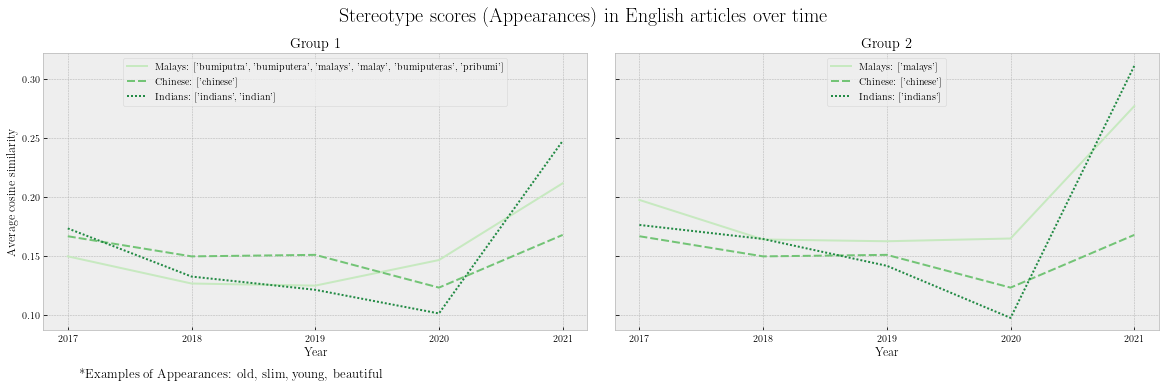

In [31]:
# Group 1 - ethnic labels appearing in every year
dist = []

for embeddings in models_by_year.values():
    dist_malay = get_average_sim(malays_filtered, appear_filtered, embeddings)
    dist_chi = get_average_sim(chinese_filtered, appear_filtered, embeddings)
    dist_ind = get_average_sim(indians_filtered, appear_filtered, embeddings)
    dist.append([dist_malay, dist_chi, dist_ind])

df_dist_1 = pd.DataFrame(dist, index = models_by_year.keys(),
                       columns =  ['Malays: {}'.format(malays_filtered), 
                                   'Chinese: {}'.format(chinese_filtered), 
                                   'Indians: {}'.format(indians_filtered)])
    
# Group 2 - manually selected labels
dist = []
for embeddings in models_by_year.values():
    dist_malay = get_average_sim(malays_manual, appear_filtered, embeddings)
    dist_chi = get_average_sim(chinese_manual, appear_filtered, embeddings)
    dist_ind = get_average_sim(indians_manual, appear_filtered, embeddings)
    dist.append([dist_malay, dist_chi, dist_ind])

df_dist_2 = pd.DataFrame(dist, index = models_by_year.keys(),
                         columns = ['Malays: {}'.format(malays_manual), 
                                    'Chinese: {}'.format(chinese_manual), 
                                    'Indians: {}'.format(indians_manual)])

fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
axes = axes.flatten()
title = 'Stereotype scores (Appearances) in English articles over time'
annotation = '*Examples of Appearances: ' + ', '.join(appear_filtered)

dfs = [df_dist_1, df_dist_2]

for idx in range(len(axes)):
    ax = axes[idx]
    sns.lineplot(data=dfs[idx], ax=ax, palette='Greens')
    ax.locator_params(integer=True)
    ax.legend(loc='upper center')
    ax.set_title('Group ' + str(idx+1)) 
    #ax.set_ybound(upper=dfs[idx].to_numpy().max())
    ax.set_xlabel("Year")
    ax.set_ylabel("Average cosine similarity")

fig.suptitle(title, fontsize=20)
plt.subplots_adjust(top=0.85, bottom=0.08, wspace=0.05, hspace=0.2)
fig.text(0.15, -0.05, annotation, transform=fig.transFigure, fontdict={'fontsize':13})
plt.savefig('figs/eng_stereo_appear.eps', format='eps')

In [32]:
qualities = ['antiislam', 'antimalay', 'antichinese', 'uncivilised', 'unprofessional', 'hurtful', 'sinful', 'shameful', 
             'unethical', 'rude', 'nasty', 'opportunist', 'clever', 'unwise', 'selfserving', 'misguided', 'fool', 'antigovernment', 
             'ungrateful', 'radicalised', 'musical', 'underrepresented', 'xenophobic', 'marginalised', 'oppressed', 'malaycentric', 
             'struggled', 'shunned', 'indigenous', 'formidable', 'envious', 'neglected', 'resettled', 'accommodating', 'reflective', 
             'unskilled', 'indifferent', 'disapproving', 'conservative', 'hateful', 'spirited', 'racebased', 'segregated', 'migrated', 
             'ignorant', 'hated', 'despicable', 'lowskilled', 'skeptical', 'dissatisfied', 'millennial', 'indianbased', 'diligent', 
             'disrespectful', 'disunited', 'corrupted', 'lazy', 'dominating', 'uneducated', 'treacherous', 'plural',  'pessimistic', 
             'traumatised', 'shortchanged', 'ethnocentric', 'superficial', 'stunted', 'unhappy', 'disloyal', 'pathetic', 'ridiculed', 
             'betrayed', 'disenfranchised', 'undocumented', 'illiterate', 'negligible', 'antigovernment', 'grassroot', 'incarcerated', 
             'nationalist', 'disenchanted', 'chauvinist', 'trustworthy', 'disheartened', 'semiskilled', 'passionate', 'antichinese', 
             'ethnicbased', 'communist', 'fractured', 'genderbased', 'notorious', 'religiouslinked', 'apathetic', 'unskilled', 
             'antiestablishment', 'lowskilled',  'wellrespected', 'indianbased', 'appreciative', 'respectable', 'prodemocracy', 
             'reputable', 'beleaguered', 'aggrieved', 'separatist', 'musical', 'lively', 'joyous', 'cherished', 'rightwing', 
             'apathetic', 'hateful', 'traditional', 'millennial', 'indianbased', 'chauvinistic', 'antimalay', 'forceful', 'disunited', 
             'holy', 'muted',  'thrilled', 'bilingual', 'ethnocentric', 'persuadable', 'loyalist', 'unhappy', 'faithful', 'commanded', 
             'nationalistic',  'negligible', 'beleaguered', 'forthright', 'homogenous', 'nationalist', 'enterprising', 'disenchanted', 
             'chauvinist', 'brisk', 'underperforming', 'trilingual', 'fledgling', 'antichinese', 'ethnicbased', 'communist', 'noisy', 'nomadic', 
             'pluralistic', 'evangelical', 'staunch', 'tumultuous', 'undignified', 'socialist', 'apolitical', 'chauvinist', 'homogenous', 
             'probumiputera', 'aspiring', 'embattled', 'grassroot', 'negligible', 'illiterate', 'ace', 'superb', 'highskilled', 'loyalist', 
             'ethnocentric', 'halfhearted', 'strategist', 'nativist', 'contented', 'patriots', 'undivided', 'upbeat', 'fledgling', 'inexperienced', 
             'pessimistic', 'semiskilled', 'forgiving', 'ultraconservative', 'exploiting', 'malaycentric', 'infidels', 'greedy', 'unprincipled', 
             'stingy', 'formidable', 'rightwing', 'apathetic', 'religiousbased', 'fractious', 'approachable', 'conservative', 'hardline', 'coward', 
             'gullible', 'energetic', 'racebased', 'powercrazy', 'obedient', 'antiestablishment', 'chinesebased', 'cynical', 'dominant', 'magnanimous', 
             'despicable', 'fickle', 'indianbased', 'racist', 'chauvinistic', 'antimalay', 'centrist', 'powerhungry', 'insecure', 'secular', 'hypocritical', 
             'clueless', 'appreciative', 'disrespectful', 'authoritarian', 'disunited', 'lazy', 'oblivious', 'arrogant', 'cursed', 'undecided', 'treacherous', 
             'loyal', 'plural', 'delusional', 'ungrateful', 'mistreated', 'rational', 'shortchanged', 'antiislam', 'liberal', 'superficial', 'dismissive', 
             'persuadable', 'disgusting', 'autocratic', 'faithful', 'disloyal', 'pathetic', 'overconfident', 'disparate', 'polarised', 'multireligious', 
             'disenfranchised', 'malaybased', 'nationalistic', 'bullied', 'commanded', 'friendlier', 'kleptocrat', 'bogeyman', 'saviour', 'antigovernment', 
             'openminded', 'tolerant', 'nationalist', 'fragmented', 'divisive', 'multicultural', 'bereft', 'disenchanted', 'disillusioned', 'rebellious', 
             'indecisive', 'colonised', 'disheartened', 'predictable', 'kleptocratic', 'diehard', 'fedup', 'ethnoreligious', 'scandalplagued', 'hypocrite', 
             'passionate', 'antichinese', 'insolent',  'entrapped', 'pious', 'fractured', 'narrowminded', 'multiethnic', 'principled', 'bumiputeracentric', 
             'prolific', 'nonpartisan', 'weakest', 'courted', 'incensed', 'fundamentalist', 'estranged', 'bilingual', 'leftist', 'humorous', 'ecstatic', 
             'upset', 'soft-spoken', 'youthcentric', 'enterprising', 'dangling', 'lowskilled', 'idealistic', 'sensible', 'diligent', 'smarter', 'highlyskilled', 
             'unskilled', 'indifferent',  'farsighted', 'receptive', 'fearless', 'selfish', 'wellversed',  'empathetic', 'healthier', 'futureready', 
             'knowledgeable', 'skilled', 'elitist', 'budding', 'materialistic', 'passive', 'choosy', 'stunted', 'productive', 'entrepreneurial',
             'employable', 'assertive', 'underserved', 'talented', 'unqualified', 'unrealistic', 'savvy', 'adaptable', 'frail', 'inefficient', 
             'tame', 'nascent', 'rudderless', 'dismayed', 'outgoing', 'reformist','vigorous', 'antikleptocracy', 'antibullying', 'proficient',
            'good', 'religious', 'criminal', 'united', 'open', 'free', 'strong', 'independent', 'negative', 'positive', 'responsible', 'fake', 
             'active', 'confident', 'great','popular', 'bad']

print(len(set(qualities)))

qualities_filtered = filter_word_by_occurrence(set(qualities), models_by_year)
print(len(qualities_filtered))
print(qualities_filtered)

294
126
['positive', 'formidable', 'oblivious', 'criminal', 'reputable', 'staunch', 'loyal', 'misguided', 'genderbased', 'disgusting', 'arrogant', 'rational', 'musical', 'fake', 'pious', 'indigenous', 'mistreated', 'pessimistic', 'open', 'trustworthy', 'semiskilled', 'betrayed', 'disrespectful', 'upbeat', 'outgoing', 'religious', 'productive', 'fragmented', 'lazy', 'independent', 'knowledgeable', 'undecided', 'notorious', 'popular', 'traditional', 'socialist', 'antimalay', 'unprofessional', 'ace', 'bullied', 'spirited', 'commanded', 'divisive', 'passive', 'fool', 'rude', 'skilled', 'aspiring', 'secular', 'courted', 'corrupted', 'active', 'holy', 'unwise', 'malaybased', 'liberal', 'ridiculed', 'responsible', 'great', 'united', 'negative', 'multireligious', 'lowskilled', 'strategist', 'grassroot', 'authoritarian', 'conservative', 'shunned', 'unethical', 'wellversed', 'reflective', 'undocumented', 'healthier', 'reformist', 'unhappy', 'upset', 'racist', 'oppressed', 'principled', 'entrepre

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


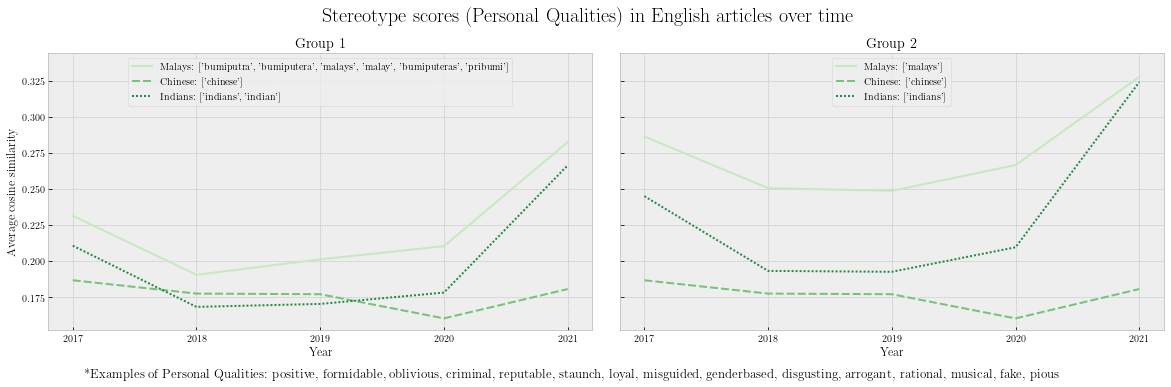

In [33]:
# Group 1 - ethnic labels appearing in every year
dist = []
for embeddings in models_by_year.values():
    dist_malay = get_average_sim(malays_filtered, qualities_filtered, embeddings)
    dist_chi = get_average_sim(chinese_filtered, qualities_filtered, embeddings)
    dist_ind = get_average_sim(indians_filtered, qualities_filtered, embeddings)
    dist.append([dist_malay, dist_chi, dist_ind])
    
df_dist_1  = pd.DataFrame(dist, index = models_by_year.keys(),
                           columns =  ['Malays: {}'.format(malays_filtered), 
                                       'Chinese: {}'.format(chinese_filtered), 
                                       'Indians: {}'.format(indians_filtered)])

# Group 2 - manually selected labels
dist = []
for embeddings in models_by_year.values():
    dist_malay = get_average_sim(malays_manual, qualities_filtered, embeddings)
    dist_chi = get_average_sim(chinese_manual, qualities_filtered, embeddings)
    dist_ind = get_average_sim(indians_manual, qualities_filtered, embeddings)
    dist.append([dist_malay, dist_chi, dist_ind])
    
df_dist_2 = pd.DataFrame(dist, index = models_by_year.keys(),
                         columns = ['Malays: {}'.format(malays_manual), 
                                    'Chinese: {}'.format(chinese_manual), 
                                    'Indians: {}'.format(indians_manual)])

fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
axes = axes.flatten()
title = 'Stereotype scores (Personal Qualities) in English articles over time'
annotation = '*Examples of Personal Qualities: ' + ', '.join(qualities_filtered[:15]) 

dfs = [df_dist_1, df_dist_2]

for idx in range(len(axes)):
    ax = axes[idx]
    sns.lineplot(data=dfs[idx], ax=ax, palette="Greens")
    ax.locator_params(integer=True)
    ax.legend(loc='upper center')
    ax.set_title('Group ' + str(idx+1)) 
    ax.set_ybound(upper=dfs[idx].to_numpy().max()*1.05)
    ax.set_xlabel("Year")
    ax.set_ylabel("Average cosine similarity")

fig.suptitle(title, fontsize=20)
plt.subplots_adjust(top=0.85, bottom=0.08, wspace=0.05, hspace=0.2)
fig.text(0.15, -0.05, annotation, transform=fig.transFigure, fontdict={'fontsize':13})
plt.savefig('figs/eng_stereo_pq.eps', format='eps')

In [34]:
economic = ['richer', 'middleclass', 'privileged', 'lowerincome', 'higherincome', 'impoverished', 
            'semirural', 'lowwage', 'affluent', 'underemployed', 'wealthy', 'semiurban', 'mediumincome', 
            'ultrarich', 'urbanites', 'welloff', 'insignificant', 'disadvantaged', 'poorer', 'provincial', 'underprivileged',
            'impoverished', 'semirural', 'suburb', 'wealthy', 'semiurban', 'urbanites', 'provincial', 'governmentaided', 
            'underdeveloped', 'powerless', 'semiurban', 'marginalised', 'suppressed', 'middleclass', 'sidelined', 'forgotten', 
            'urbanites',  'semirural', 'welloff', 'insignificant', 'workingclass', 'underrepresented', 'richer', 'urbanised', 
            'disadvantaged', 'highincome', 'lowerincome', 'higherincome', 'impoverished', 'lowwage', 'mediumincome', 'midincome', 
            'selfreliant', 'suburban', 'poorer', 'middleincome', 'poorest', 'rural', 'urban', 'industrial']
print(len(set(economic)))

economic_filtered = filter_word_by_occurrence(set(economic), models_by_year)
print(len(economic_filtered))
print(economic_filtered)

41
23
['affluent', 'richer', 'wealthy', 'urban', 'rural', 'impoverished', 'lowerincome', 'semiurban', 'suppressed', 'industrial', 'suburban', 'suburb', 'middleincome', 'underprivileged', 'forgotten', 'poorest', 'poorer', 'disadvantaged', 'privileged', 'powerless', 'sidelined', 'highincome', 'marginalised']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


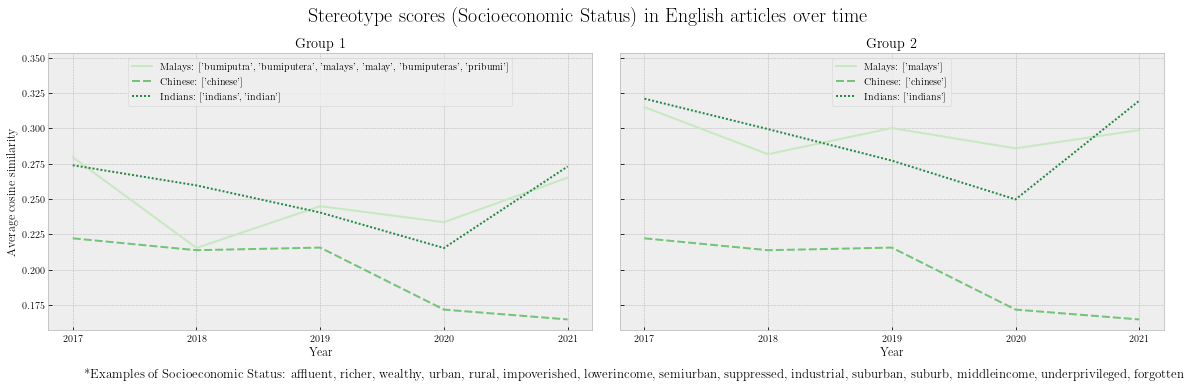

In [36]:
# Group 1 - ethnic labels appearing in every year
dist = []

for embeddings in models_by_year.values():
    dist_malay = get_average_sim(malays_filtered, economic_filtered, embeddings)
    dist_chi = get_average_sim(chinese_filtered, economic_filtered, embeddings)
    dist_ind = get_average_sim(indians_filtered, economic_filtered, embeddings)
    dist.append([dist_malay, dist_chi, dist_ind])
    
df_dist_1  = pd.DataFrame(dist, index = models_by_year.keys(),
                           columns =  ['Malays: {}'.format(malays_filtered), 
                                       'Chinese: {}'.format(chinese_filtered), 
                                       'Indians: {}'.format(indians_filtered)])

# Group 2 - manually selected labels
dist = []
for embeddings in models_by_year.values():
    dist_malay = get_average_sim(malays_manual, economic_filtered, embeddings)
    dist_chi = get_average_sim(chinese_manual, economic_filtered, embeddings)
    dist_ind = get_average_sim(indians_manual, economic_filtered, embeddings)
    dist.append([dist_malay, dist_chi, dist_ind])
    
df_dist_2 = pd.DataFrame(dist, index = models_by_year.keys(),
                         columns = ['Malays: {}'.format(malays_manual), 
                                    'Chinese: {}'.format(chinese_manual), 
                                    'Indians: {}'.format(indians_manual)])

fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
axes = axes.flatten()
title = 'Stereotype scores (Socioeconomic Status) in English articles over time'
annotation = '*Examples of Socioeconomic Status: ' + ', '.join(economic_filtered[:15]) 

dfs = [df_dist_1, df_dist_2]

for idx in range(len(axes)):
    ax = axes[idx]
    sns.lineplot(data=dfs[idx], ax=ax, palette="Greens")
    ax.locator_params(integer=True)
    ax.legend(loc='upper center')
    ax.set_title('Group ' + str(idx+1)) 
    ax.set_ybound(upper=dfs[idx].to_numpy().max()*1.1)
    ax.set_xlabel("Year")
    ax.set_ylabel("Average cosine similarity")

fig.suptitle(title, fontsize=20)
plt.subplots_adjust(top=0.85, bottom=0.08, wspace=0.05, hspace=0.2)
fig.text(0.15, -0.05, annotation, transform=fig.transFigure, fontdict={'fontsize':13})
plt.savefig('figs/eng_stereo_ss.eps', format='eps')

In [37]:
occupations = ['educator', 'influencer', 'obstetrician', 'housewives', 'academician', 'chefs', 'educationists', 
               'carmaker', 'educationist', 'pharmacist',  'televangelist', 'entrepreneurs', 'agropreneur', 'farmer', 'boatman',
              'teacher', 'author', 'mechanic', 'broker', 'baker', 'surveyor', 'laborer', 'surgeon', 'gardener', 'painter', 
               'dentist', 'janitor', ' athlete', 'manager', 'conductor', 'carpenter', 'housekeeper', 'secretary', 'economist', 
               'geologist', 'clerk', 'doctor', 'judge', 'physician', ' lawyer', 'artist', 'instructor', 'dancer', 'photographer', 
               'inspector', 'musician', 'soldier', 'librarian', 'professor', 'psychologist', ' nurse', 'sailor', 'accountant', 
               'architect', 'chemist', 'administrator', 'physicist', 'scientist', 'farmer', 'janitor', 'statistician', 'midwife', 
               'midwives', 'bailiff', 'auctioneer', 'photographer', 'geologist', 'shoemaker', 'athlete', 'cashier', 'dancer', 'housekeeper', 
               'accountant', 'physicist', 'gardener', 'dentist', 'weaver', 'blacksmith', 'psychologist', 'supervisor', 'mathematician', 
               'surveyor', 'tailor', 'designer', 'economist', 'mechanic', 'laborer', 'postmaster', 'broker', 'chemist', 'librarian', 
               'attendant', 'clerical', 'musician', 'porter', 'scientist', 'carpenter', 'sailor', 'instructor', 'sheriff', 'pilot', 
               'inspector', 'mason', 'baker', 'administrator', 'architect', 'collector', 'operator', 'surgeon', 'driver', 'painter', 
               'conductor', 'nurse', 'cook', 'engineer', 'retired', 'sales', 'lawyer', 'clergy', 'physician', 'farmer', 'clerk', 
               'manager', 'guard', 'artist', 'smith', 'official', 'police', 'doctor', 'professor', 'student', 'judge', 'teacher', 
               'author', 'secretary', 'soldier']

print(len(set(occupations)))

occu_filtered = filter_word_by_occurrence(set(occupations), models_by_year)
print(len(occu_filtered))
print(occu_filtered)

94
44
['pilot', 'broker', 'inspector', 'scientist', 'author', 'photographer', 'student', 'doctor', 'guard', 'soldier', 'athlete', 'administrator', 'clerk', 'judge', 'secretary', 'lawyer', 'pharmacist', 'manager', 'mechanic', 'farmer', 'statistician', 'artist', 'psychologist', 'physician', 'police', 'engineer', 'teacher', 'official', 'professor', 'attendant', 'chemist', 'chefs', 'operator', 'entrepreneurs', 'accountant', 'sales', 'driver', 'designer', 'supervisor', 'retired', 'economist', 'nurse', 'surgeon', 'cook']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


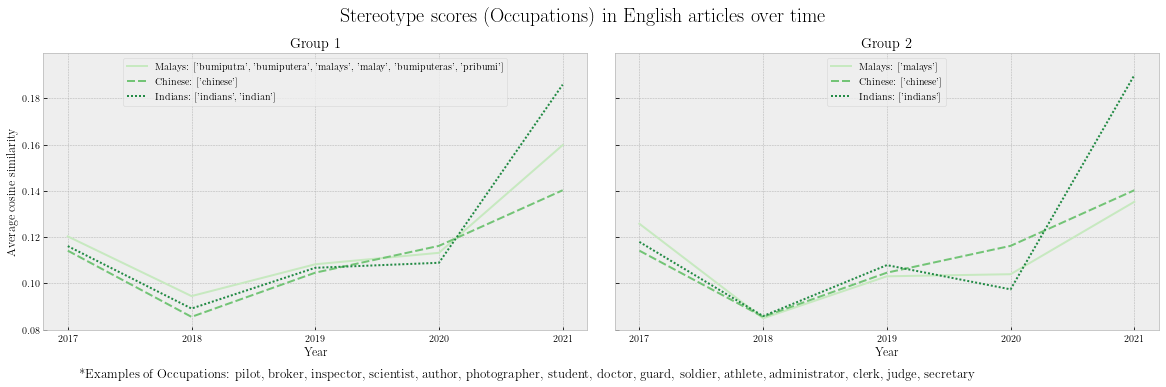

In [38]:
# Group 1 - ethnic labels appearing in every year
dist = []
for embeddings in models_by_year.values():
    dist_malay = get_average_sim(malays_filtered, occu_filtered, embeddings)
    dist_chi = get_average_sim(chinese_filtered, occu_filtered, embeddings)
    dist_ind = get_average_sim(indians_filtered, occu_filtered, embeddings)
    dist.append([dist_malay, dist_chi, dist_ind])
    
df_dist_1  = pd.DataFrame(dist, index = models_by_year.keys(),
                           columns =  ['Malays: {}'.format(malays_filtered), 
                                       'Chinese: {}'.format(chinese_filtered), 
                                       'Indians: {}'.format(indians_filtered)])

# Group 2 - manually selected labels
dist = []
for embeddings in models_by_year.values():
    dist_malay = get_average_sim(malays_manual, occu_filtered, embeddings)
    dist_chi = get_average_sim(chinese_manual, occu_filtered, embeddings)
    dist_ind = get_average_sim(indians_manual, occu_filtered, embeddings)
    dist.append([dist_malay, dist_chi, dist_ind])
    
df_dist_2 = pd.DataFrame(dist, index = models_by_year.keys(),
                         columns = ['Malays: {}'.format(malays_manual), 
                                    'Chinese: {}'.format(chinese_manual), 
                                    'Indians: {}'.format(indians_manual)])

fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
axes = axes.flatten()
title = 'Stereotype scores (Occupations) in English articles over time'
annotation = '*Examples of Occupations: ' + ', '.join(occu_filtered[:15]) 

dfs = [df_dist_1, df_dist_2]

for idx in range(len(axes)):
    ax = axes[idx]
    sns.lineplot(data=dfs[idx], ax=ax, palette="Greens")
    ax.locator_params(integer=True)
    ax.legend(loc='upper center')
    ax.set_title('Group ' + str(idx+1)) 
    ax.set_ybound(upper=dfs[idx].to_numpy().max()*1.05)
    ax.set_xlabel("Year")
    ax.set_ylabel("Average cosine similarity")

fig.suptitle(title, fontsize=20)
plt.subplots_adjust(top=0.85, bottom=0.08, wspace=0.05, hspace=0.2)
fig.text(0.15, -0.05, annotation, transform=fig.transFigure, fontdict={'fontsize':13})
plt.savefig('figs/eng_stereo_occu.eps', format='eps')

Text(0.15, -0.05, '*Examples of Personal Qualities: positive, formidable, oblivious, criminal, reputable, staunch, loyal, misguided, genderbased, disgusting, arrogant, rational, musical, fake, pious')

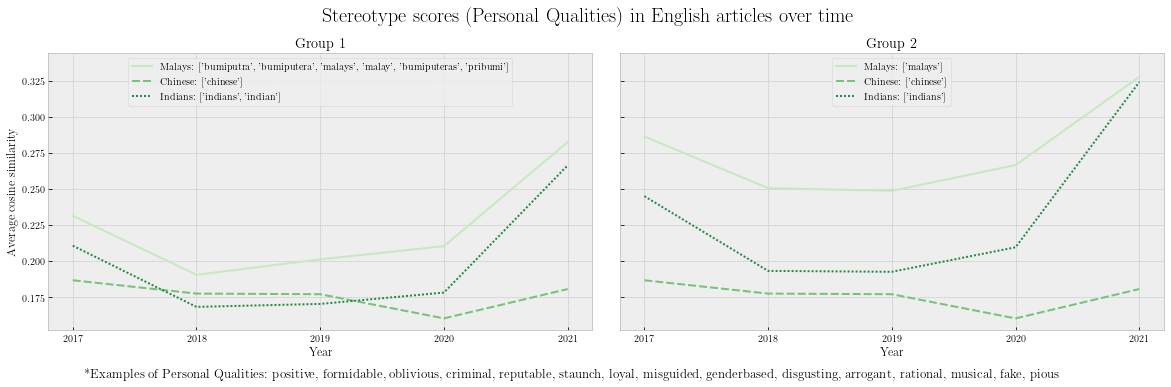

In [30]:
adj_ibrahim = ['lazy', 'religious', 'conservative', 'friendly', 'racist']

# Group 1 - ethnic labels appearing in every year
dist = []
for embeddings in models_by_year.values():
    dist_malay = get_average_sim(malays_filtered, qualities_filtered, embeddings)
    dist_chi = get_average_sim(chinese_filtered, qualities_filtered, embeddings)
    dist_ind = get_average_sim(indians_filtered, qualities_filtered, embeddings)
    dist.append([dist_malay, dist_chi, dist_ind])
    
df_dist_1  = pd.DataFrame(dist, index = models_by_year.keys(),
                           columns =  ['Malays: {}'.format(malays_filtered), 
                                       'Chinese: {}'.format(chinese_filtered), 
                                       'Indians: {}'.format(indians_filtered)])

# Group 2 - manually selected labels
dist = []
for embeddings in models_by_year.values():
    dist_malay = get_average_sim(malays_manual, qualities_filtered, embeddings)
    dist_chi = get_average_sim(chinese_manual, qualities_filtered, embeddings)
    dist_ind = get_average_sim(indians_manual, qualities_filtered, embeddings)
    dist.append([dist_malay, dist_chi, dist_ind])
    
df_dist_2 = pd.DataFrame(dist, index = models_by_year.keys(),
                         columns = ['Malays: {}'.format(malays_manual), 
                                    'Chinese: {}'.format(chinese_manual), 
                                    'Indians: {}'.format(indians_manual)])

fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
axes = axes.flatten()
title = 'Stereotype scores (Personal Qualities) in English articles over time'
annotation = '*Examples of Personal Qualities: ' + ', '.join(qualities_filtered[:15]) 

dfs = [df_dist_1, df_dist_2]

for idx in range(len(axes)):
    ax = axes[idx]
    sns.lineplot(data=dfs[idx], ax=ax, palette="Greens")
    ax.locator_params(integer=True)
    ax.legend(loc='upper center')
    ax.set_title('Group ' + str(idx+1)) 
    ax.set_ybound(upper=dfs[idx].to_numpy().max()*1.05)
    ax.set_xlabel("Year")
    ax.set_ylabel("Average cosine similarity")

fig.suptitle(title, fontsize=20)
plt.subplots_adjust(top=0.85, bottom=0.08, wspace=0.05, hspace=0.2)
fig.text(0.15, -0.05, annotation, transform=fig.transFigure, fontdict={'fontsize':13})

In [207]:
get_close_word('bumiputras', models_by_year, 20)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
2018,ibans,kadazans,primed,sbp,grouped,sjkts,nonchinese,conforming,homosexuals,nationaltype,noncitizens,simpai,ethnocentric,fluently,joblessness,asylumseekers,vocabulary,stam,leavers,heartlands


In [10]:
get_close_word('chinese', models_by_year, 20)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
2017,vernacular,nationaltype,indians,indian,ethnic,jiao,tamil,zong,nationals,parentage,automaker,zongs,nonchinese,telugu,huazong,emigration,dpmm,sjkcs,siamese,overwhelmingly
2018,guilds,indians,ethnic,hokkien,ibans,kadazans,vernacular,punjabi,zong,huazong,telugu,malays,colonialists,indian,rooster,keqiang,iban,predominantly,jiao,xi
2019,indians,kadazans,indian,ethnic,ibans,zheng,educationists,siamese,lunar,nonchinese,phantom,zhao,fictitious,wooing,kadazan,pau,outnumber,zhong,alienate,spenders
2020,nationals,indians,indian,cny,educationist,ethnic,decorations,lunar,clan,ghosts,chinas,teochew,ibans,china,lanterns,redcoloured,bai,nonchinese,sikhs,kadazandusun
2021,lunar,indian,oranges,clan,hokkien,lantern,countdown,usher,chauvinist,eve,reunion,dayak,kadazan,tombsweeping,sccci,christmas,celebrating,celebrations,buddhists,cny


In [33]:
get_close_word('indians', models_by_year, 20)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
2017,kadazans,ethnic,malays,ibans,sizeable,underclass,nonmalay,disenfranchised,overwhelmingly,bangladeshis,kingmakers,malaymuslims,ethnicities,pakistanis,kdm,dayaks,chinese,bidayuh,nonbumiputera,buddhists
2018,ibans,kadazans,malays,ethnic,bumiputras,natives,ethnicities,primed,indian,sikhs,bumiputeras,pendatang,nonmalays,battled,homosexuals,chinese,overwhelmingly,harmoniously,communitys,statelessness
2019,kadazans,ibans,malays,chinese,ethnic,rantaus,semirural,ultrarich,grooms,aslimajority,kadazan,ethnicities,indian,dayaks,sizeable,middleclass,heartland,voters,spenders,semiurban
2020,ethnic,kadazan,ibans,indian,pakistanis,chinese,females,sikhs,ethnicity,percentages,ethnicities,raciallycharged,malays,natives,europeans,indifferent,bumiputeras,burmese,sixty,bogeyman
2021,ethnicities,ethnicity,ethnic,electorate,malays,males,kadazan,liberalism,discord,sympathisers,cultures,nonmalays,z,pessimistic,impunity,rohingyas,millennials,demographic,inclined,races
